# **Task 2: Understanding  Vision Transformers**

# **Part 1. Using pre-trained VIT for Image Classification**

Using device: cpu



LOADING PRE-TRAINED VISION TRANSFORMER (ViT) - IMAGENET


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Model: google/vit-base-patch16-224
Pre-trained on: ImageNet-1k (1000 classes)
Image size: 224×224 pixels
Patch size: 16×16
Number of patches: (224/16)² = 196 patches
Number of parameters: 86.6M

PREPARING TEST IMAGES
✓ Loaded image 1: (640, 480)
✓ Loaded image 2: (427, 640)
✓ Loaded image 3: (640, 640)

Total images loaded: 3
Note: Images will be resized to 224×224 by the processor

Saved: vit_test_images.png


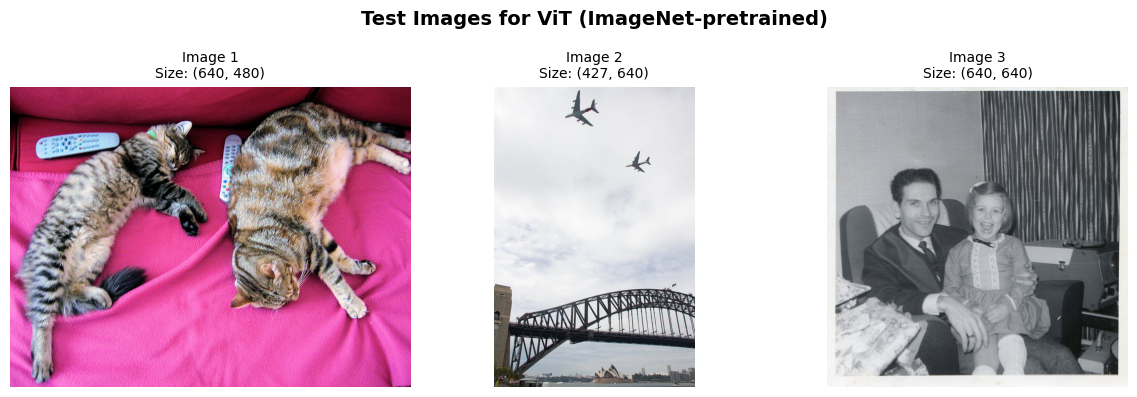


RUNNING INFERENCE

Predictions:
----------------------------------------------------------------------

Image 1:
  Top-1 Prediction: Egyptian cat
  Confidence: 93.74%
  Top-5 Predictions:
    1. Egyptian cat: 93.74%
    2. tabby, tabby cat: 3.84%
    3. tiger cat: 1.44%
    4. lynx, catamount: 0.33%
    5. Siamese cat, Siamese: 0.07%

Image 2:
  Top-1 Prediction: steel arch bridge
  Confidence: 96.31%
  Top-5 Predictions:
    1. steel arch bridge: 96.31%
    2. pier: 2.15%
    3. warplane, military plane: 0.11%
    4. airship, dirigible: 0.09%
    5. seashore, coast, seacoast, sea-coast: 0.08%

Image 3:
  Top-1 Prediction: bow tie, bow-tie, bowtie
  Confidence: 61.37%
  Top-5 Predictions:
    1. bow tie, bow-tie, bowtie: 61.37%
    2. Windsor tie: 5.12%
    3. suit, suit of clothes: 4.58%
    4. academic gown, academic robe, judge's robe: 1.20%
    5. nipple: 1.09%
----------------------------------------------------------------------

Saved: vit_predictions.png


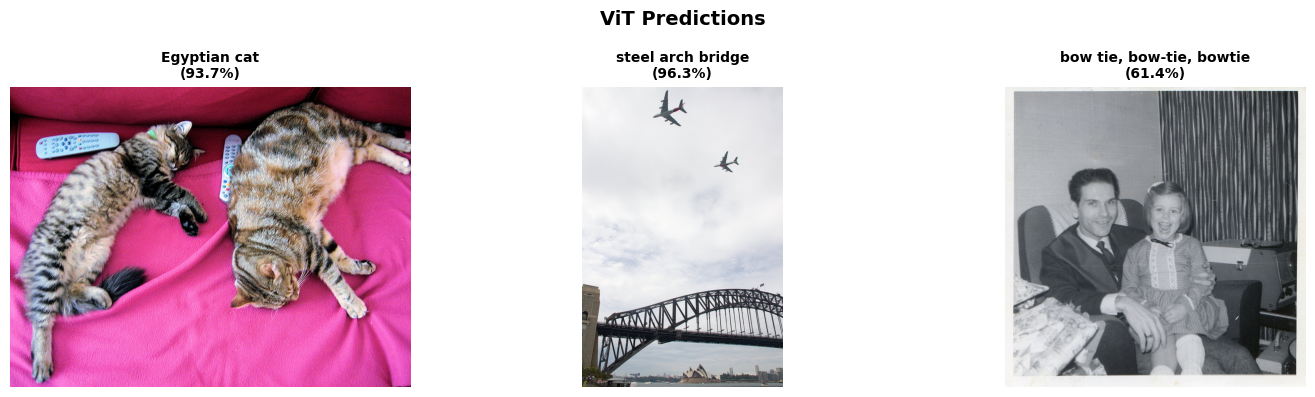


ASSESSMENT OF PREDICTIONS

Are the predictions reasonable?

Image 1:
  Predicted: Egyptian cat (93.74%)
  Assessment: High confidence prediction

Image 2:
  Predicted: steel arch bridge (96.31%)
  Assessment: High confidence prediction

Image 3:
  Predicted: bow tie, bow-tie, bowtie (61.37%)
  Assessment: Moderate confidence


In [ ]:
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load pre-trained ViT model from HuggingFace (ImageNet-1k)
from transformers import ViTImageProcessor, ViTForImageClassification

print("\n" + "="*70)
print("LOADING PRE-TRAINED VISION TRANSFORMER (ViT) - IMAGENET")
print("="*70)

# load ViT-Base model pre-trained on ImageNet-1k (1000 classes)
model_name = "google/vit-base-patch16-224"  # Pre-trained on ImageNet-1k
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model = model.to(device)
model.eval()

print(f"\nModel: {model_name}")
print(f"Pre-trained on: ImageNet-1k (1000 classes)")
print(f"Image size: 224×224 pixels")
print(f"Patch size: 16×16")
print(f"Number of patches: (224/16)² = 196 patches")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

print("\n" + "="*70)
print("PREPARING TEST IMAGES")
print("="*70)

# use ImageNet sample images from URLs
image_urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",  # Cats
    "http://images.cocodataset.org/val2017/000000001761.jpg",  # Dog
    "http://images.cocodataset.org/val2017/000000292082.jpg",  # Elephant
]
# use the first set
images = []
for idx, url in enumerate(image_urls):
    try:
        response = requests.get(url, timeout=10)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        images.append(image)
        print(f"✓ Loaded image {idx+1}: {image.size}")
    except Exception as e:
        print(f"✗ Error loading image {idx+1}: {e}")

if len(images) == 0:
    print("\nFailed to load images from URLs. Creating dummy images...")
    # create dummy images as fallback
    import numpy as np
    for i in range(3):
        dummy = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
        images.append(dummy)

print(f"\nTotal images loaded: {len(images)}")
print("Note: Images will be resized to 224×224 by the processor")


# display original images
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for idx, img in enumerate(images):
    if len(images) > 1:
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Image {idx+1}\nSize: {img.size}', fontsize=10)
    else:
        axes.imshow(img)
        axes.axis('off')
        axes.set_title(f'Image 1\nSize: {img.size}')

plt.suptitle('Test Images for ViT (ImageNet-pretrained)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_test_images.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_test_images.png")
plt.show()
# Process images and get predictions
print("\n" + "="*70)
print("RUNNING INFERENCE")
print("="*70)

# process images
inputs = processor(images=images, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# get predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# get predicted class indices and probabilities
predicted_class_indices = logits.argmax(dim=-1).cpu().numpy()
probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

# get class labels
print("\nPredictions:")
print("-"*70)
for idx, (img, class_idx, probs) in enumerate(zip(images, predicted_class_indices, probabilities)):
    predicted_label = model.config.id2label[class_idx]
    confidence = probs[class_idx] * 100

    print(f"\nImage {idx+1}:")
    print(f"  Top-1 Prediction: {predicted_label}")
    print(f"  Confidence: {confidence:.2f}%")

    # get top-5 predictions
    top5_indices = np.argsort(probs)[-5:][::-1]
    print(f"  Top-5 Predictions:")
    for rank, top_idx in enumerate(top5_indices, 1):
        label = model.config.id2label[top_idx]
        conf = probs[top_idx] * 100
        print(f"    {rank}. {label}: {conf:.2f}%")

print("-"*70)


# visualize predictions
fig, axes = plt.subplots(1, len(images), figsize=(15, 4))

for idx, (img, class_idx, probs) in enumerate(zip(images, predicted_class_indices, probabilities)):
    predicted_label = model.config.id2label[class_idx]
    confidence = probs[class_idx] * 100

    if len(images) > 1:
        ax = axes[idx]
    else:
        ax = axes

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{predicted_label}\n({confidence:.1f}%)',
                 fontsize=10, fontweight='bold')

plt.suptitle('ViT Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_predictions.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_predictions.png")
plt.show()


# record results
print("\n" + "="*70)
print("ASSESSMENT OF PREDICTIONS")
print("="*70)

print("\nAre the predictions reasonable?")
for idx, (class_idx, probs) in enumerate(zip(predicted_class_indices, probabilities)):
    predicted_label = model.config.id2label[class_idx]
    confidence = probs[class_idx] * 100

    print(f"\nImage {idx+1}:")
    print(f"  Predicted: {predicted_label} ({confidence:.2f}%)")

    # Manual assessment (you should verify by looking at images)
    if confidence > 70:
        print(f"  Assessment: High confidence prediction")
    elif confidence > 40:
        print(f"  Assessment: Moderate confidence")
    else:
        print(f"  Assessment: Low confidence, uncertain")



# **Part 2: Visualizing Patch Attention**

In [ ]:
# reload the model with "eager" attention implementation

print("Reloading model with attn_implementation='eager'...")
model = ViTForImageClassification.from_pretrained(
    model_name,
    attn_implementation="eager"
)
model = model.to(device)
model.eval()

# configure it to output attentions
model.config.output_attentions = True

# process the image again
test_image = images[0]
inputs_att = processor(images=[test_image], return_tensors="pt")
inputs_att = {k: v.to(device) for k, v in inputs_att.items()}

# run Inference
with torch.no_grad():
    outputs = model(**inputs_att)

# extract Attentions (This will definitely work now)
attentions = outputs.attentions

print(f"\nSuccess!")
print(f"Number of transformer layers: {len(attentions)}")
print(f"Attention shape per layer: {attentions[0].shape}")


# calculate Grid Size for Visualization
last_layer_attention = attentions[-1]
num_patches = last_layer_attention.shape[2] - 1
grid_size = int(np.sqrt(num_patches))
print(f"Grid size: {grid_size}x{grid_size} = {num_patches} patches")

Reloading model with attn_implementation='eager'...

Success!
Number of transformer layers: 12
Attention shape per layer: torch.Size([1, 12, 197, 197])
Grid size: 14x14 = 196 patches


In [ ]:
# extract CLS token attention to patches
# get attention from CLS token (index 0) to all other tokens
cls_attention = last_layer_attention[0, :, 0, 1:]  # shape: [num_heads, num_patches]
num_heads = cls_attention.shape[0]
num_patches = cls_attention.shape[1]


print(f"\nCLS attention to patches shape: {cls_attention.shape}")
print(f"  [num_heads={num_heads}, num_patches={num_patches}]")

# show attention values for each head
print("\nAttention statistics per head:")
print(f"  {'Head':<8} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
print(f"  {'-'*60}")
for head_idx in range(num_heads):
    head_attn = cls_attention[head_idx].cpu().numpy()
    print(f"  {head_idx:<8} {head_attn.min():<12.6f} {head_attn.max():<12.6f} "
          f"{head_attn.mean():<12.6f} {head_attn.std():<12.6f}")


CLS attention to patches shape: torch.Size([12, 196])
  [num_heads=12, num_patches=196]

Attention statistics per head:
  Head     Min          Max          Mean         Std         
  ------------------------------------------------------------
  0        0.000024     0.045098     0.005100     0.008775    
  1        0.000005     0.035377     0.005101     0.007846    
  2        0.000258     0.043403     0.005092     0.007286    
  3        0.000080     0.051337     0.005100     0.006599    
  4        0.000025     0.153236     0.005101     0.013869    
  5        0.000284     0.027236     0.005095     0.006065    
  6        0.000031     0.116026     0.005100     0.019117    
  7        0.000009     0.036648     0.005098     0.007394    
  8        0.000065     0.143910     0.005100     0.013486    
  9        0.000012     0.048587     0.005101     0.008375    
  10       0.000473     0.020806     0.005085     0.004594    
  11       0.000033     0.067838     0.005081     0.011424  

In [ ]:
# Aggregate attention heads
# average over all heads
attention_avg = cls_attention.mean(dim=0)  # Shape: [num_patches]
print(f"\nAverage attention shape: {attention_avg.shape}")
attention_map = attention_avg.cpu().numpy()

print(f"\nAttention map statistics (averaged):")
print(f"  Min:  {attention_map.min():.6f}")
print(f"  Max:  {attention_map.max():.6f}")
print(f"  Mean: {attention_map.mean():.6f}")
print(f"  Sum:  {attention_map.sum():.6f} (should be ≈ 1.0)")




Average attention shape: torch.Size([196])

Attention map statistics (averaged):
  Min:  0.000360
  Max:  0.034533
  Mean: 0.005096
  Sum:  0.998853 (should be ≈ 1.0)


In [ ]:
# reshape attention to 2D spatial grid
# calculate grid size
grid_size = int(np.sqrt(num_patches))  # should be 14 for 224x224 image with 16x16 patches
print(f"Grid size: {grid_size} × {grid_size}")

# reshape attention vector to 2D grid
attention_2d = attention_map.reshape(grid_size, grid_size)
print(f"2D attention map shape: {attention_2d.shape}")

# view 2D attention map
print(f"\n2D Attention map sample (top-left 5×5):")
print(attention_2d[:5, :5])


Grid size: 14 × 14
2D attention map shape: (14, 14)

2D Attention map sample (top-left 5×5):
[[0.00334425 0.00135296 0.00094687 0.00177558 0.00130335]
 [0.00814857 0.00363967 0.00320388 0.00692165 0.01402062]
 [0.00702103 0.00643325 0.00740065 0.01044995 0.00200168]
 [0.00764941 0.00929549 0.00293495 0.00331982 0.00605515]
 [0.00179794 0.002681   0.00720166 0.01021182 0.00973411]]


Upsampled attention map shape: (224, 224)
Image shape: (224, 224, 3)

Saved: vit_attention_visualization.png


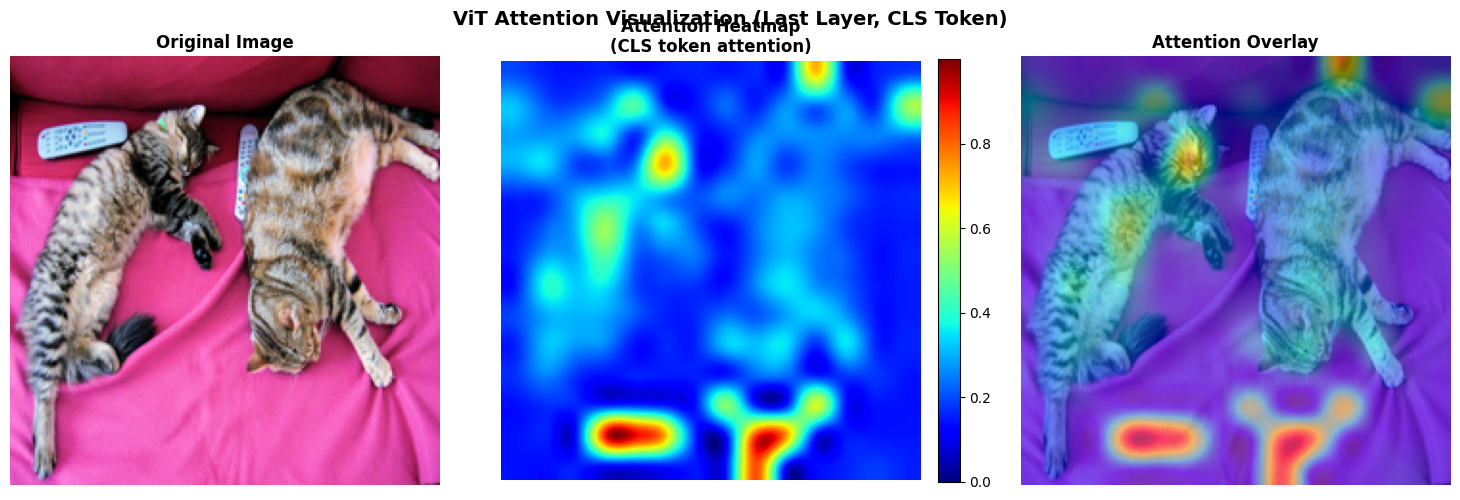

In [ ]:
# visualize the attention map ( sampled and unsampled)

import cv2

# resize test image to 224x224 if needed
test_image_resized = test_image.resize((224, 224))
test_image_np = np.array(test_image_resized)

# upsample attention map to image resolution (224x224)
attention_upsampled = cv2.resize(attention_2d, (224, 224), interpolation=cv2.INTER_CUBIC)

# normalize to [0, 1] for visualization
attention_normalized = (attention_upsampled - attention_upsampled.min()) / \
                       (attention_upsampled.max() - attention_upsampled.min() + 1e-8)

print(f"Upsampled attention map shape: {attention_upsampled.shape}")
print(f"Image shape: {test_image_np.shape}")

# create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. original image
axes[0].imshow(test_image_resized)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. attention map (heatmap)
im = axes[1].imshow(attention_normalized, cmap='jet', interpolation='bilinear')
axes[1].set_title('Attention Heatmap\n(CLS token attention)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

# 3. overlay on image
axes[2].imshow(test_image_resized)
axes[2].imshow(attention_normalized, cmap='jet', alpha=0.5, interpolation='bilinear')
axes[2].set_title('Attention Overlay', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle('ViT Attention Visualization (Last Layer, CLS Token)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_attention_visualization.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_attention_visualization.png")
plt.show()

Saved: vit_attention_heads.png


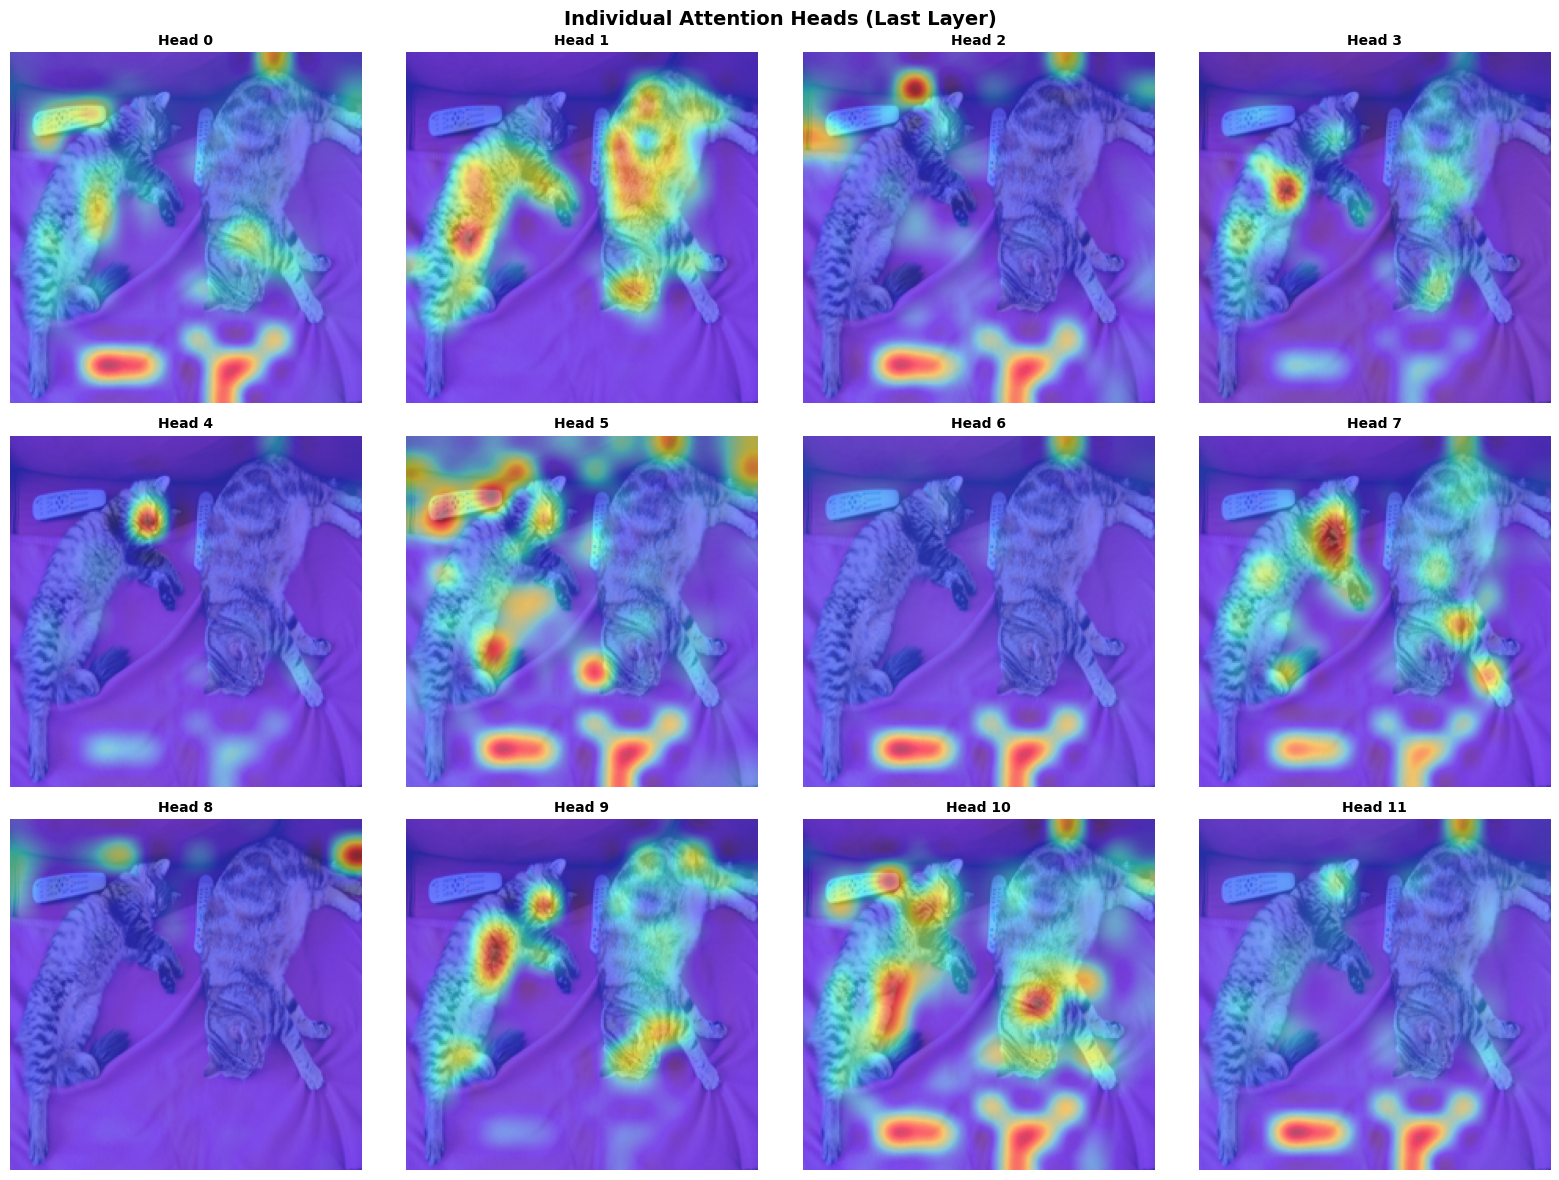

In [ ]:
# visualize the idividual attention heads

num_heads_to_show = min(12, num_heads)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for head_idx in range(num_heads_to_show):
    # get attention for this head
    head_attention = cls_attention[head_idx].cpu().numpy()

    # reshape to 2D
    head_attention_2d = head_attention.reshape(grid_size, grid_size)

    # upsample
    head_attention_upsampled = cv2.resize(head_attention_2d, (224, 224),
                                         interpolation=cv2.INTER_CUBIC)

    # normalize
    head_attention_norm = (head_attention_upsampled - head_attention_upsampled.min()) / \
                          (head_attention_upsampled.max() - head_attention_upsampled.min() + 1e-8)

    # plot
    axes[head_idx].imshow(test_image_resized, alpha=0.7)
    axes[head_idx].imshow(head_attention_norm, cmap='jet', alpha=0.5, interpolation='bilinear')
    axes[head_idx].set_title(f'Head {head_idx}', fontsize=10, fontweight='bold')
    axes[head_idx].axis('off')

plt.suptitle('Individual Attention Heads (Last Layer)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_attention_heads.png', dpi=300, bbox_inches='tight')
print("Saved: vit_attention_heads.png")
plt.show()

Saved: vit_all_images_attention.png


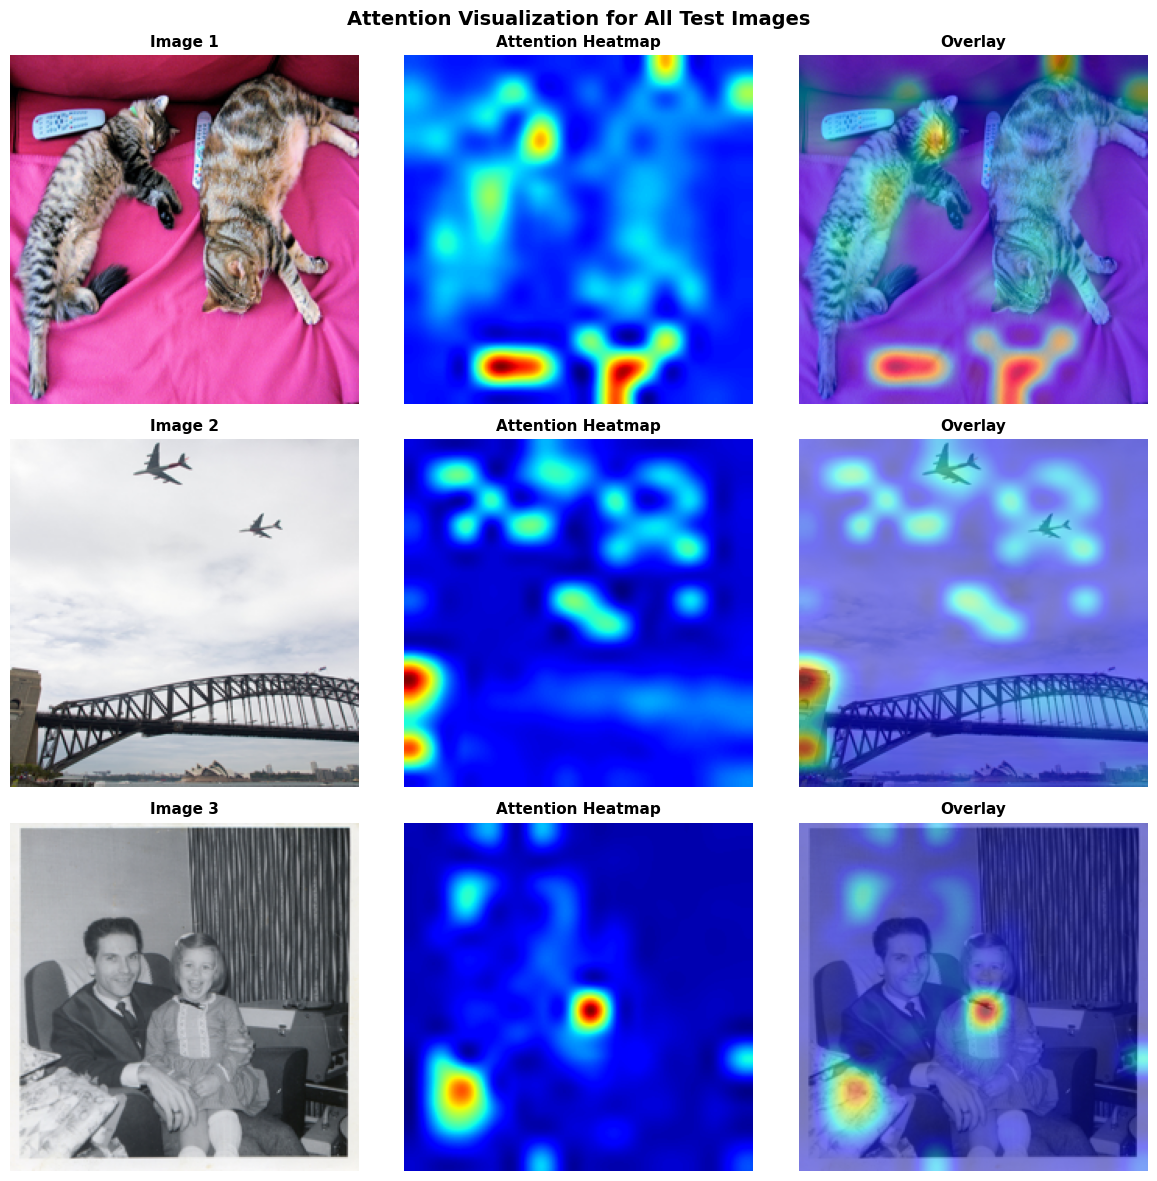

In [ ]:
# visualize attention across all images
fig, axes = plt.subplots(len(images), 3, figsize=(12, 4*len(images)))

for img_idx, image in enumerate(images):
    # process image
    inputs = processor(images=[image], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # get last layer CLS attention
    last_attn = outputs.attentions[-1]
    cls_attn = last_attn[0, :, 0, 1:].mean(dim=0).cpu().numpy()

    # reshape and upsample
    attn_2d = cls_attn.reshape(grid_size, grid_size)

    image_resized = image.resize((224, 224))
    attn_upsampled = cv2.resize(attn_2d, (224, 224), interpolation=cv2.INTER_CUBIC)
    attn_normalized = (attn_upsampled - attn_upsampled.min()) / \
                      (attn_upsampled.max() - attn_upsampled.min() + 1e-8)

    # plot
    row_axes = axes[img_idx] if len(images) > 1 else axes

    # original
    row_axes[0].imshow(image_resized)
    row_axes[0].set_title(f'Image {img_idx+1}', fontsize=11, fontweight='bold')
    row_axes[0].axis('off')

    # heatmap
    im = row_axes[1].imshow(attn_normalized, cmap='jet')
    row_axes[1].set_title('Attention Heatmap', fontsize=11, fontweight='bold')
    row_axes[1].axis('off')

    # overlay
    row_axes[2].imshow(image_resized)
    row_axes[2].imshow(attn_normalized, cmap='jet', alpha=0.5)
    row_axes[2].set_title('Overlay', fontsize=11, fontweight='bold')
    row_axes[2].axis('off')

plt.suptitle('Attention Visualization for All Test Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_all_images_attention.png', dpi=300, bbox_inches='tight')
print("Saved: vit_all_images_attention.png")
plt.show()

# **Part 3: Analyze the attention Map**



Saved: vit_attention_comprehensive.png


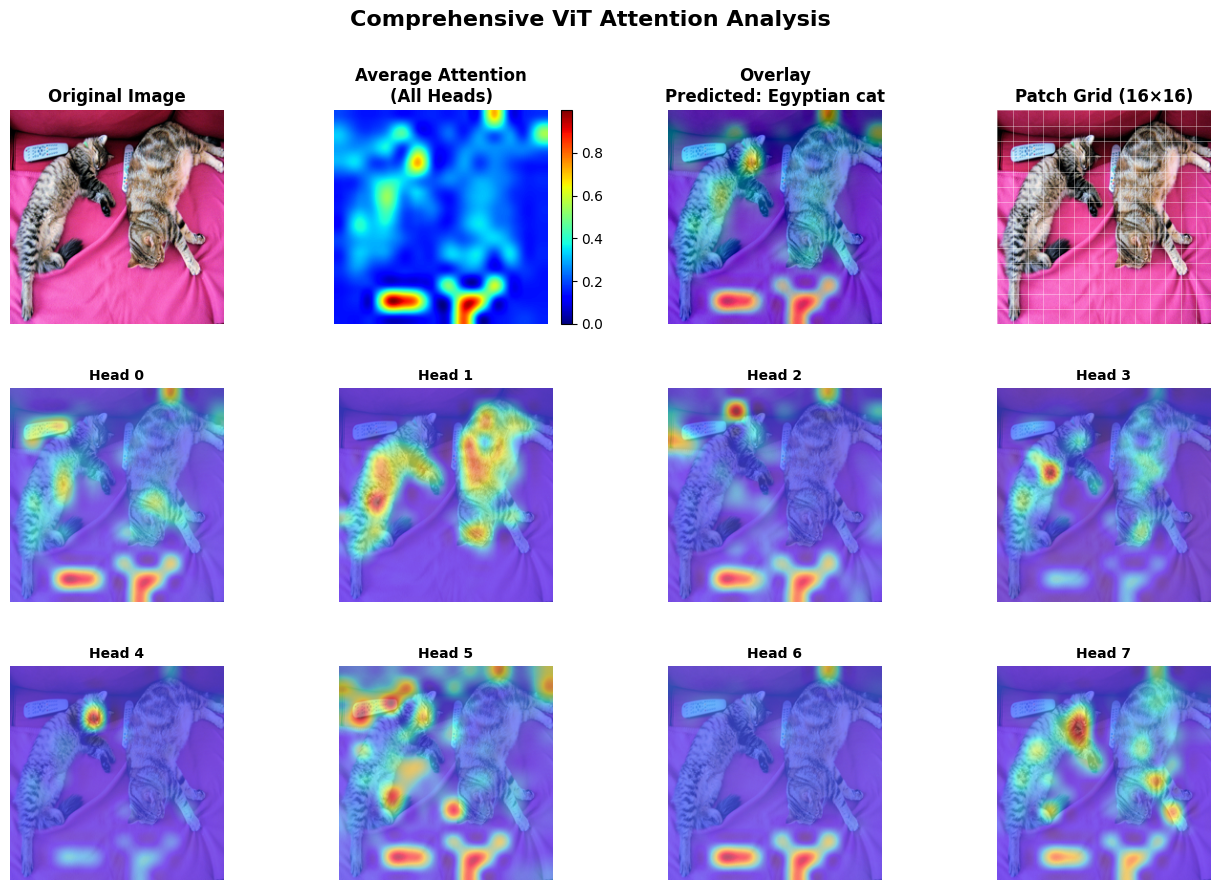

In [ ]:
# create a  summary figure
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# use first image for detailed analysis
test_idx = 0
image = images[test_idx].resize((224, 224))
predicted_label = model.config.id2label[predicted_class_indices[test_idx]]

# re-extract attention
inputs = processor(images=[images[test_idx]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

last_attn = outputs.attentions[-1]
cls_attn = last_attn[0, :, 0, 1:]

# row 1: Original, Average attention, Overlay
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(image)
ax1.set_title('Original Image', fontweight='bold')
ax1.axis('off')

# average attention
attn_avg = cls_attn.mean(dim=0).cpu().numpy().reshape(14, 14)
attn_avg_up = cv2.resize(attn_avg, (224, 224), interpolation=cv2.INTER_CUBIC)
attn_avg_norm = (attn_avg_up - attn_avg_up.min()) / (attn_avg_up.max() - attn_avg_up.min() + 1e-8)

ax2 = fig.add_subplot(gs[0, 1])
im = ax2.imshow(attn_avg_norm, cmap='jet')
ax2.set_title('Average Attention\n(All Heads)', fontweight='bold')
ax2.axis('off')
plt.colorbar(im, ax=ax2, fraction=0.046)

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(image)
ax3.imshow(attn_avg_norm, cmap='jet', alpha=0.5)
ax3.set_title(f'Overlay\nPredicted: {predicted_label}', fontweight='bold')
ax3.axis('off')

# patch grid
ax4 = fig.add_subplot(gs[0, 3])
ax4.imshow(image)
# draw patch grid
for i in range(0, 224, 16):
    ax4.axhline(i, color='white', linewidth=0.5, alpha=0.5)
    ax4.axvline(i, color='white', linewidth=0.5, alpha=0.5)
ax4.set_title('Patch Grid (16×16)', fontweight='bold')
ax4.axis('off')

# row 2-3: Individual heads
for head_idx in range(8):
    row = 1 + head_idx // 4
    col = head_idx % 4

    head_attn = cls_attn[head_idx].cpu().numpy().reshape(14, 14)
    head_attn_up = cv2.resize(head_attn, (224, 224), interpolation=cv2.INTER_CUBIC)
    head_attn_norm = (head_attn_up - head_attn_up.min()) / (head_attn_up.max() - head_attn_up.min() + 1e-8)

    ax = fig.add_subplot(gs[row, col])
    ax.imshow(image, alpha=0.6)
    ax.imshow(head_attn_norm, cmap='jet', alpha=0.5)
    ax.set_title(f'Head {head_idx}', fontweight='bold', fontsize=10)
    ax.axis('off')

plt.suptitle('Comprehensive ViT Attention Analysis', fontsize=16, fontweight='bold')
plt.savefig('vit_attention_comprehensive.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_attention_comprehensive.png")
plt.show()



# **Part 4: Mask a fraction of input patches and observe effect**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy

# function to mask patches
def mask_patches(pixel_values, mask_ratio=0.5, mask_type='random', patch_size=16):
    batch_size, channels, height, width = pixel_values.shape

    # calculate number of patches
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    total_patches = num_patches_h * num_patches_w

    # number of patches to mask
    num_masked = int(total_patches * mask_ratio)

    # create copy
    masked_values = pixel_values.clone()

    if mask_type == 'random':
        # randomly select patches to mask
        all_patch_indices = list(range(total_patches))
        mask_indices = np.random.choice(all_patch_indices, num_masked, replace=False)

    elif mask_type == 'center':
        # mask center patches
        center_h = num_patches_h // 2
        center_w = num_patches_w // 2
        radius = int(np.sqrt(num_masked) / 2)

        mask_indices = []
        for i in range(max(0, center_h - radius), min(num_patches_h, center_h + radius)):
            for j in range(max(0, center_w - radius), min(num_patches_w, center_w + radius)):
                if len(mask_indices) < num_masked:
                    mask_indices.append(i * num_patches_w + j)
        mask_indices = np.array(mask_indices)

    elif mask_type == 'edges':
        # mask edge patches
        mask_indices = []
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if i == 0 or i == num_patches_h-1 or j == 0 or j == num_patches_w-1:
                    mask_indices.append(i * num_patches_w + j)
        # randomly select from edge patches
        mask_indices = np.random.choice(mask_indices, min(num_masked, len(mask_indices)), replace=False)

    else:
        raise ValueError(f"Unknown mask_type: {mask_type}")

    # apply masking
    for idx in mask_indices:
        patch_h = idx // num_patches_w
        patch_w = idx % num_patches_w

        h_start = patch_h * patch_size
        h_end = h_start + patch_size
        w_start = patch_w * patch_size
        w_end = w_start + patch_size

        # set patch to 0 (black)
        masked_values[:, :, h_start:h_end, w_start:w_end] = 0

    return masked_values, mask_indices


# test the masking function
test_image = images[0]
inputs = processor(images=[test_image], return_tensors="pt")
pixel_values = inputs['pixel_values']

print(f"\nOriginal input shape: {pixel_values.shape}")
print(f"Number of patches: 14 × 14 = 196")




Original input shape: torch.Size([1, 3, 224, 224])
Number of patches: 14 × 14 = 196


Mask Ratio:   0.0% | Prediction: Egyptian cat                   | Confidence:  93.74%
Mask Ratio:  10.0% | Prediction: Egyptian cat                   | Confidence:  92.49%
Mask Ratio:  25.0% | Prediction: Egyptian cat                   | Confidence:  86.83%
Mask Ratio:  50.0% | Prediction: Egyptian cat                   | Confidence:  44.49%
Mask Ratio:  75.0% | Prediction: tabby, tabby cat               | Confidence:  35.80%

Original prediction (0% masked): Egyptian cat

Saved: vit_random_masking.png


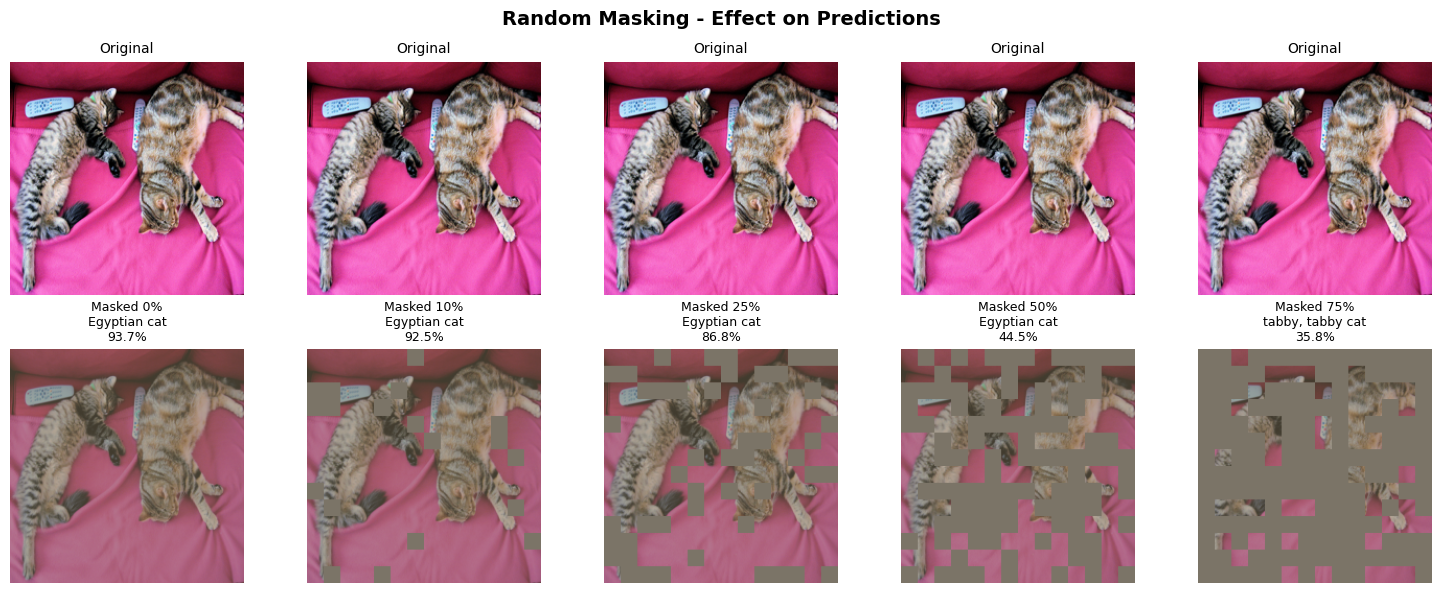

In [ ]:
# experiement 1: different masking ratios witg random masking

# test different masking ratios
mask_ratios = [0.0, 0.1, 0.25, 0.5, 0.75]
results_random = []

for ratio in mask_ratios:
    # mask patches
    if ratio == 0.0:
        masked_values = pixel_values
    else:
        masked_values, _ = mask_patches(pixel_values, mask_ratio=ratio, mask_type='random')

    # run inference
    with torch.no_grad():
        outputs = model(pixel_values=masked_values.to(device))
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        pred_idx = logits.argmax(dim=-1).item()
        confidence = probs[0, pred_idx].item() * 100
        pred_label = model.config.id2label[pred_idx]

    results_random.append({
        'ratio': ratio,
        'pred_idx': pred_idx,
        'pred_label': pred_label,
        'confidence': confidence,
        'masked_values': masked_values
    })

    print(f"Mask Ratio: {ratio*100:>5.1f}% | Prediction: {pred_label:<30} | Confidence: {confidence:>6.2f}%")

original_pred = model.config.id2label[predicted_class_indices[0]]
print(f"\nOriginal prediction (0% masked): {original_pred}")

# plot results

fig, axes = plt.subplots(2, len(mask_ratios), figsize=(15, 6))

for idx, result in enumerate(results_random):
    ratio = result['ratio']
    masked_img = result['masked_values'][0].permute(1, 2, 0).cpu().numpy()

    # Denormalize for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    masked_img = masked_img * std + mean
    masked_img = np.clip(masked_img, 0, 1)

    # Original image
    axes[0, idx].imshow(images[0].resize((224, 224)))
    axes[0, idx].set_title(f'Original', fontsize=10)
    axes[0, idx].axis('off')

    # Masked image
    axes[1, idx].imshow(masked_img)
    axes[1, idx].set_title(f'Masked {ratio*100:.0f}%\n{result["pred_label"][:20]}\n{result["confidence"]:.1f}%',
                          fontsize=9)
    axes[1, idx].axis('off')

plt.suptitle('Random Masking - Effect on Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_random_masking.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_random_masking.png")
plt.show()


Masking Type: Random (50%)
  Prediction: tabby, tabby cat
  Confidence: 37.96%

Masking Type: Center (50%)
  Prediction: Egyptian cat
  Confidence: 83.63%

Masking Type: Edges (30%)
  Prediction: Egyptian cat
  Confidence: 72.09%

Saved: vit_structured_masking.png


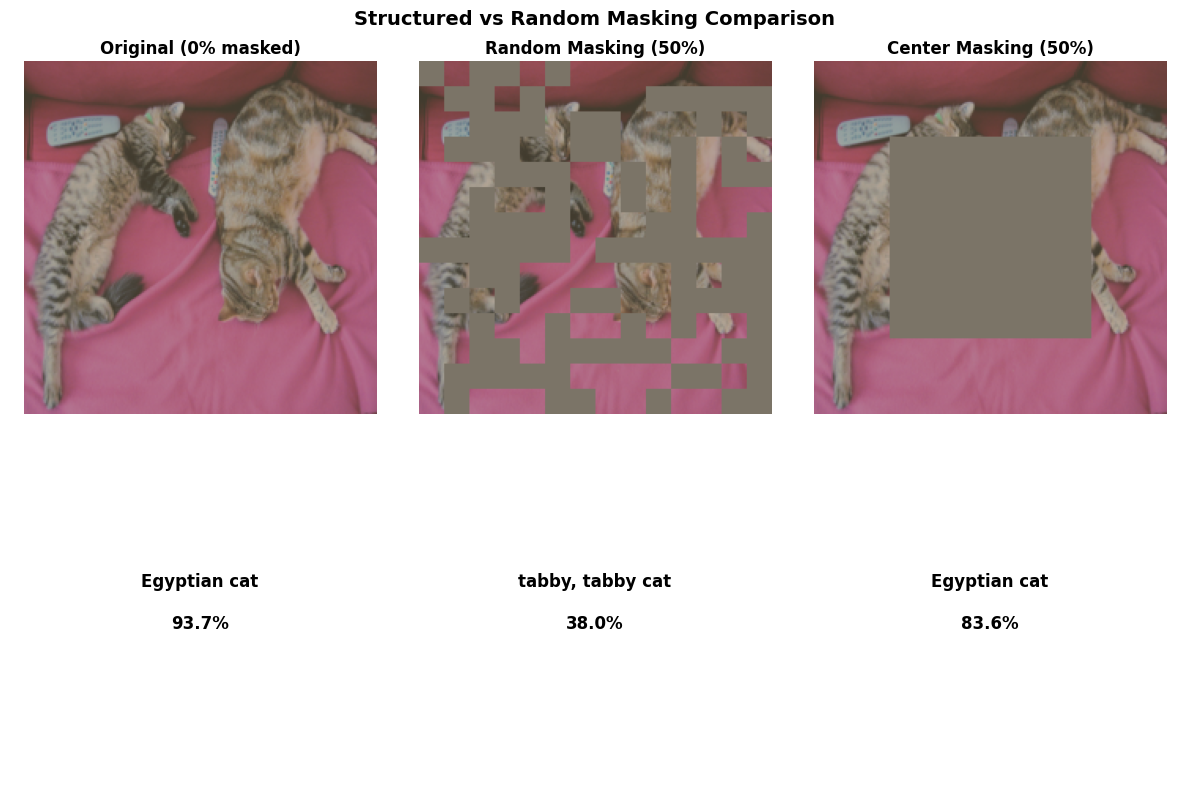

In [ ]:
# experiemnt2: structured making (center vs random)

# compare center masking vs random masking at 50%
mask_ratio = 0.5

# random masking
masked_random, _ = mask_patches(pixel_values, mask_ratio=0.5, mask_type='random')
with torch.no_grad():
    outputs_random = model(pixel_values=masked_random.to(device))
    pred_random = outputs_random.logits.argmax(dim=-1).item()
    conf_random = torch.nn.functional.softmax(outputs_random.logits, dim=-1)[0, pred_random].item() * 100
    label_random = model.config.id2label[pred_random]

# center masking
masked_center, _ = mask_patches(pixel_values, mask_ratio=0.5, mask_type='center')
with torch.no_grad():
    outputs_center = model(pixel_values=masked_center.to(device))
    pred_center = outputs_center.logits.argmax(dim=-1).item()
    conf_center = torch.nn.functional.softmax(outputs_center.logits, dim=-1)[0, pred_center].item() * 100
    label_center = model.config.id2label[pred_center]

# edge masking
masked_edges, _ = mask_patches(pixel_values, mask_ratio=0.3, mask_type='edges')
with torch.no_grad():
    outputs_edges = model(pixel_values=masked_edges.to(device))
    pred_edges = outputs_edges.logits.argmax(dim=-1).item()
    conf_edges = torch.nn.functional.softmax(outputs_edges.logits, dim=-1)[0, pred_edges].item() * 100
    label_edges = model.config.id2label[pred_edges]

print(f"\nMasking Type: Random (50%)")
print(f"  Prediction: {label_random}")
print(f"  Confidence: {conf_random:.2f}%")

print(f"\nMasking Type: Center (50%)")
print(f"  Prediction: {label_center}")
print(f"  Confidence: {conf_center:.2f}%")

print(f"\nMasking Type: Edges (30%)")
print(f"  Prediction: {label_edges}")
print(f"  Confidence: {conf_edges:.2f}%")

# visualize structured masking
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# helper function to denormalize
def denormalize(img_tensor):
    img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

# row 1: masked images
axes[0, 0].imshow(denormalize(pixel_values))
axes[0, 0].set_title('Original (0% masked)', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(denormalize(masked_random))
axes[0, 1].set_title('Random Masking (50%)', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(denormalize(masked_center))
axes[0, 2].set_title('Center Masking (50%)', fontweight='bold')
axes[0, 2].axis('off')

# row 2: rredictions
axes[1, 0].text(0.5, 0.5, f'{original_pred}\n\n{probabilities[0][predicted_class_indices[0]]*100:.1f}%',
                ha='center', va='center', fontsize=12, fontweight='bold',
                transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

axes[1, 1].text(0.5, 0.5, f'{label_random}\n\n{conf_random:.1f}%',
                ha='center', va='center', fontsize=12, fontweight='bold',
                transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

axes[1, 2].text(0.5, 0.5, f'{label_center}\n\n{conf_center:.1f}%',
                ha='center', va='center', fontsize=12, fontweight='bold',
                transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')

plt.suptitle('Structured vs Random Masking Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('vit_structured_masking.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_structured_masking.png")
plt.show()


# **Part 5: Compare linear probes on CLS token vs mean pooling**

In [ ]:
# extract features using both pooling methods
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

# use CIFAR-10 for linear probe evaluation
print("\n" + "="*70)
print("PREPARING DATASET: CIFAR-10")
print("="*70)

# CIFAR-10 dataset
transform_probe = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_probe = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_probe
)
test_dataset_probe = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_probe
)

train_loader_probe = DataLoader(train_dataset_probe, batch_size=64, shuffle=True, num_workers=2)
test_loader_probe = DataLoader(test_dataset_probe, batch_size=64, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset_probe)}")
print(f"Test samples: {len(test_dataset_probe)}")


def extract_features_vit(model, dataloader, pooling_method='cls', max_samples=5000):
    model.eval()

    all_features = []
    all_labels = []

    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            if count >= max_samples:
                break

            images = images.to(device)

            # get hidden states from ViT
            outputs = model.vit(images, output_hidden_states=True)

            # last hidden state: [batch, seq_len, hidden_dim]
            # seq_len = 197 (1 CLS + 196 patches for 224x224 image with 16x16 patches)
            last_hidden_state = outputs.last_hidden_state

            if pooling_method == 'cls':
                # use CLS token (first token)
                features = last_hidden_state[:, 0, :]  # [batch, hidden_dim]

            elif pooling_method == 'mean':
                # mean pooling over all patch tokens (exclude CLS)
                patch_tokens = last_hidden_state[:, 1:, :]  # [batch, num_patches, hidden_dim]
                features = patch_tokens.mean(dim=1)  # [batch, hidden_dim]

            else:
                raise ValueError(f"Unknown pooling method: {pooling_method}")

            all_features.append(features.cpu())
            all_labels.append(labels)

            count += images.size(0)

    all_features = torch.cat(all_features, dim=0)[:max_samples]
    all_labels = torch.cat(all_labels, dim=0)[:max_samples]

    return all_features, all_labels


print("\n" + "="*70)
print("EXTRACTING FEATURES")
print("="*70)

# extract features using CLS token
print("\nExtracting features with CLS token pooling...")
train_features_cls, train_labels_cls = extract_features_vit(
    model, train_loader_probe, pooling_method='cls', max_samples=5000
)
test_features_cls, test_labels_cls = extract_features_vit(
    model, test_loader_probe, pooling_method='cls', max_samples=1000
)

print(f"CLS - Train features shape: {train_features_cls.shape}")
print(f"CLS - Test features shape:  {test_features_cls.shape}")

# extract features using mean pooling
print("\nExtracting features with mean pooling...")
train_features_mean, train_labels_mean = extract_features_vit(
    model, train_loader_probe, pooling_method='mean', max_samples=5000
)
test_features_mean, test_labels_mean = extract_features_vit(
    model, test_loader_probe, pooling_method='mean', max_samples=1000
)

print(f"Mean - Train features shape: {train_features_mean.shape}")
print(f"Mean - Test features shape:  {test_features_mean.shape}")



PREPARING DATASET: CIFAR-10
Training samples: 50000
Test samples: 10000

EXTRACTING FEATURES

Extracting features with CLS token pooling...
CLS - Train features shape: torch.Size([5000, 768])
CLS - Test features shape:  torch.Size([1000, 768])

Extracting features with mean pooling...
Mean - Train features shape: torch.Size([5000, 768])
Mean - Test features shape:  torch.Size([1000, 768])


In [ ]:
# test liear prob on both featurs set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("\n" + "="*70)
print("TRAINING LINEAR PROBES")
print("="*70)

# linear probe on CLS token features
print("\n1. Training linear probe on CLS token features...")
clf_cls = LogisticRegression(max_iter=1000, random_state=42, verbose=1)
clf_cls.fit(train_features_cls.numpy(), train_labels_cls.numpy())

pred_cls = clf_cls.predict(test_features_cls.numpy())
acc_cls = accuracy_score(test_labels_cls.numpy(), pred_cls) * 100

print(f"CLS Token Linear Probe Accuracy: {acc_cls:.2f}%")

# linear probe on mean pooled features
print("\n2. Training linear probe on mean pooled features...")
clf_mean = LogisticRegression(max_iter=1000, random_state=42, verbose=1)
clf_mean.fit(train_features_mean.numpy(), train_labels_mean.numpy())

pred_mean = clf_mean.predict(test_features_mean.numpy())
acc_mean = accuracy_score(test_labels_mean.numpy(), pred_mean) * 100

print(f"Mean Pooling Linear Probe Accuracy: {acc_mean:.2f}%")


TRAINING LINEAR PROBES

1. Training linear probe on CLS token features...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


CLS Token Linear Probe Accuracy: 91.70%

2. Training linear probe on mean pooled features...
Mean Pooling Linear Probe Accuracy: 91.90%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished



COMPARISON AND ANALYSIS

Pooling Method       Accuracy        Difference     
--------------------------------------------------
CLS Token            91.70          % -              
Mean Pooling         91.90          % +0.20%
--------------------------------------------------

Better Method: Mean Pooling
Performance gain: 0.20%

Saved: vit_pooling_comparison.png


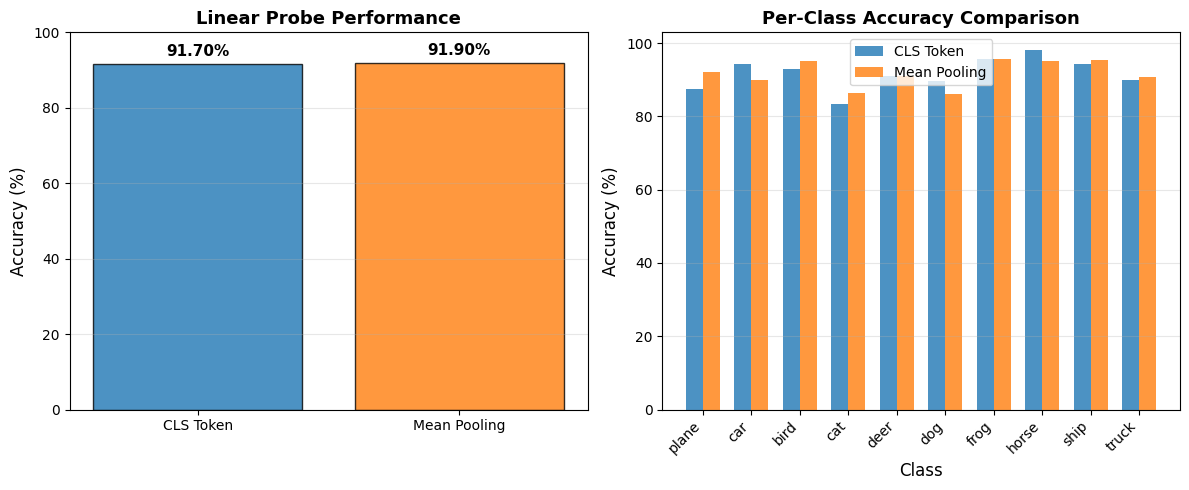

In [ ]:
# compare results
print("\n" + "="*70)
print("COMPARISON AND ANALYSIS")
print("="*70)

print(f"\n{'Pooling Method':<20} {'Accuracy':<15} {'Difference':<15}")
print("-" * 50)
print(f"{'CLS Token':<20} {acc_cls:<15.2f}% {'-':<15}")
print(f"{'Mean Pooling':<20} {acc_mean:<15.2f}% {acc_mean - acc_cls:+.2f}%")
print("-" * 50)

# determine winner
if acc_cls > acc_mean:
    winner = "CLS Token"
    diff = acc_cls - acc_mean
elif acc_mean > acc_cls:
    winner = "Mean Pooling"
    diff = acc_mean - acc_cls
else:
    winner = "Tie"
    diff = 0

print(f"\nBetter Method: {winner}")
if diff > 0:
    print(f"Performance gain: {diff:.2f}%")

# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# bar chart
methods = ['CLS Token', 'Mean Pooling']
accuracies = [acc_cls, acc_mean]
colors = ['#1f77b4', '#ff7f0e']

axes[0].bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Linear Probe Performance', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

# add value labels
for i, (method, acc) in enumerate(zip(methods, accuracies)):
    axes[0].text(i, acc + 2, f'{acc:.2f}%', ha='center', fontsize=11, fontweight='bold')

# per-class comparison
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cls = confusion_matrix(test_labels_cls.numpy(), pred_cls)
cm_mean = confusion_matrix(test_labels_mean.numpy(), pred_mean)

# calculate per-class accuracy
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_acc_cls = cm_cls.diagonal() / cm_cls.sum(axis=1) * 100
class_acc_mean = cm_mean.diagonal() / cm_mean.sum(axis=1) * 100

x = np.arange(len(class_names))
width = 0.35

axes[1].bar(x - width/2, class_acc_cls, width, label='CLS Token', alpha=0.8)
axes[1].bar(x + width/2, class_acc_mean, width, label='Mean Pooling', alpha=0.8)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Per-Class Accuracy Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('vit_pooling_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: vit_pooling_comparison.png")
plt.show()

